# Лабораторная работа 4 — Регрессионный анализ
**Вариант 1 — medical_diagnosis.csv**

### Часть 1. Кластеризация искусственных данных (make_data)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    fowlkes_mallows_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
)

from scipy.cluster.hierarchy import dendrogram, linkage

sns.set_theme(style="whitegrid", context="notebook")
RANDOM_STATE = 42

В этом блоке подключаются все используемые библиотеки:

- `numpy`, `pandas` — работа с числовыми массивами и табличными данными;
- `matplotlib.pyplot`, `seaborn` — построение графиков;
- модули `sklearn.preprocessing`, `sklearn.cluster`, `sklearn.metrics` — стандартизация признаков, алгоритмы кластеризации (KMeans, AgglomerativeClustering) и метрики качества;
- `scipy.cluster.hierarchy` — функции для иерархической кластеризации и построения дендрограмм.

Также задаётся стиль оформления графиков и фиксируется `RANDOM_STATE = 42` для воспроизводимости результатов. Этот блок подготавливает окружение для дальнейших вычислений и визуализаций.

In [2]:
def make_data(n, seed):
    np.random.seed(seed)

    shift_matrix = np.array([
        [3, 3],
        [6, 9],
        [9, 3]
    ])

    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    data = np.swapaxes(data, 1, 2)
    data = data.reshape((-1, 2))
    data *= np.array([[20, 0.5]])

    df = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]}, columns=['x', 'y'])
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return df

#генерируем данные: n можно взять от 30 до 100
n_per_cluster = 60
df_synth = make_data(n_per_cluster, seed=RANDOM_STATE)

df_synth.head(), df_synth.shape


(            x         y
 0   31.753926  0.506216
 1   57.687034  1.328643
 2  180.204661  1.161419
 3  136.270344  4.529104
 4  155.044336  0.892906,
 (180, 2))

Здесь определяется функция `make_data`, которая:

- генерирует три кластера точек в двумерном пространстве вокруг заранее заданных центров;
- добавляет сдвиги к координатам, немного масштабирует данные;
- собирает полученные точки в `DataFrame` с признаками `x` и `y`;
- перемешивает строки, чтобы объекты разных кластеров шли в случайном порядке.

После этого функция вызывается с `n_per_cluster = 60`, формируя искусственный набор данных `df_synth`. Вывод первых строк и формы таблицы позволяет убедиться, что данные сгенерированы корректно и содержат нужное количество объектов.

##### 1.2. Стандартизация признаков x и y

In [3]:
scaler_synth = StandardScaler()
X_synth_scaled = scaler_synth.fit_transform(df_synth[['x', 'y']])


В этом блоке выполняется стандартизация признаков `x` и `y` искусственного набора:

- создаётся объект `StandardScaler`;
- по данным `df_synth[['x', 'y']]` вычисляются средние и стандартные отклонения;
- значения признаков преобразуются так, что каждый столбец имеет среднее около 0 и дисперсию 1.

Стандартизация необходима, чтобы при кластеризации оба признака вносили сопоставимый вклад в расстояние между точками, и результат не зависел от исходного масштаба измерений.

##### 1.3. Кластеризация методом k-means при k=3

Коэффициент силуэта для k=3: 0.7240


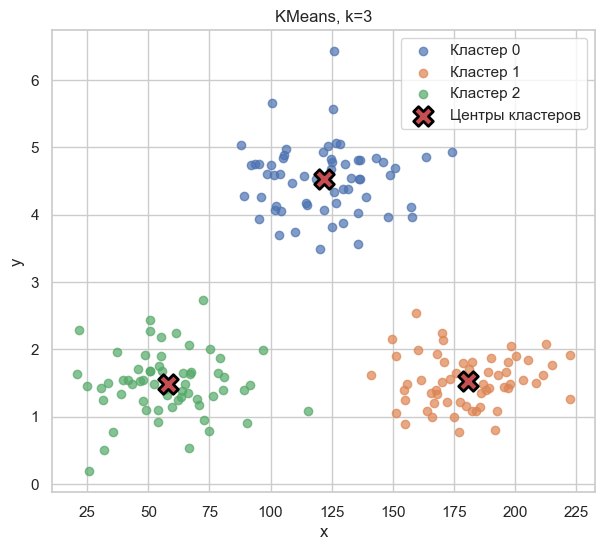

In [4]:
k3 = 3
kmeans_3 = KMeans(n_clusters=k3, random_state=RANDOM_STATE, n_init="auto")
labels_3 = kmeans_3.fit_predict(X_synth_scaled)

df_synth['cluster_k3'] = labels_3

#центры в исходном масштабе
centers_3_scaled = kmeans_3.cluster_centers_
centers_3 = scaler_synth.inverse_transform(centers_3_scaled)

sil_3 = silhouette_score(X_synth_scaled, labels_3)
print(f"Коэффициент силуэта для k=3: {sil_3:.4f}")

plt.figure(figsize=(7, 6))
for cl in range(k3):
    subset = df_synth[df_synth['cluster_k3'] == cl]
    plt.scatter(subset['x'], subset['y'], label=f'Кластер {cl}', alpha=0.7)

plt.scatter(
    centers_3[:, 0],
    centers_3[:, 1],
    marker='X',
    s=200,
    linewidths=2,
    edgecolor='black',
    label='Центры кластеров'
)

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'KMeans, k={k3}')
plt.legend()
plt.show()


Здесь проводится кластеризация искусственных данных методом KMeans при числе кластеров `k = 3`:

- модель `KMeans` обучается на стандартизированных данных `X_synth_scaled`;
- для каждого объекта вычисляется номер кластера, который сохраняется в столбце `cluster_k3`;
- центры кластеров переводятся обратно в исходный масштаб признаков;
- рассчитывается коэффициент силуэта — мера того, насколько хорошо точки отделены и насколько плотны кластеры;
- строится график: точки отображаются в координатах `x`–`y`, раскрашиваются по кластерам, а центры помечаются крупными маркерами.

По визуализации и значению силуэта можно сделать вывод, насколько хорошо KMeans восстанавливает исходное разбиение на три кластера в синтетических данных.

##### 1.4. KMeans для k=2 и k=4: сравнение метрики силуэта

k=2: коэффициент силуэта = 0.4979


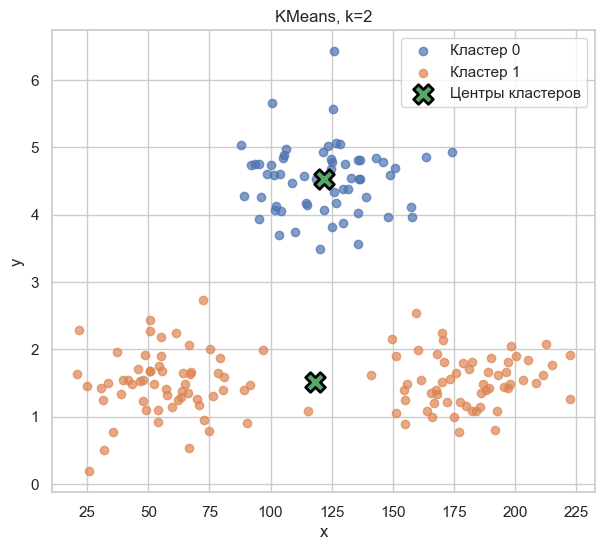

k=3: коэффициент силуэта = 0.7240


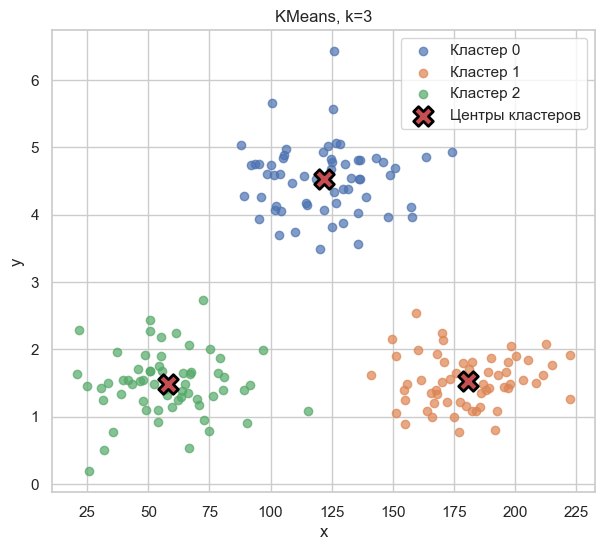

k=4: коэффициент силуэта = 0.5924


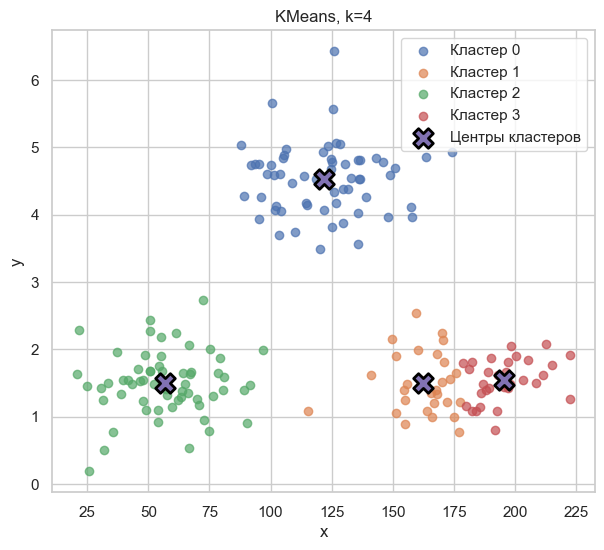

{2: 0.4978500045907247, 3: 0.7239509928717648, 4: 0.5924432842308298}

In [5]:
sil_scores = {}

for k in [2, 3, 4]:
    model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    labels = model.fit_predict(X_synth_scaled)
    sil = silhouette_score(X_synth_scaled, labels)
    sil_scores[k] = sil
    print(f"k={k}: коэффициент силуэта = {sil:.4f}")

    # Визуализация
    centers_scaled = model.cluster_centers_
    centers = scaler_synth.inverse_transform(centers_scaled)

    plt.figure(figsize=(7, 6))
    for cl in range(k):
        subset = df_synth[labels == cl]
        plt.scatter(subset['x'], subset['y'], label=f'Кластер {cl}', alpha=0.7)

    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        marker='X',
        s=200,
        linewidths=2,
        edgecolor='black',
        label='Центры кластеров'
    )

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'KMeans, k={k}')
    plt.legend()
    plt.show()

sil_scores


В этом блоке сравнивается работа KMeans при разных значениях числа кластеров `k = 2, 3, 4`:

- для каждого `k` обучается отдельная модель KMeans;
- вычисляется коэффициент силуэта и выводится в консоль;
- строятся отдельные графики рассевания с раскраской по кластерам и отмеченными центрами.

Таким образом, мы получаем как численное, так и визуальное сравнение разбиений. Можно увидеть, что при неверном числе кластеров некоторые группы «слипаются» или, наоборот, искусственно дробятся. Максимальное значение силуэта обычно соответствует «наиболее естественному» числу кластеров для данных.

##### 1.5. График по "методу локтя" для искусственных данных

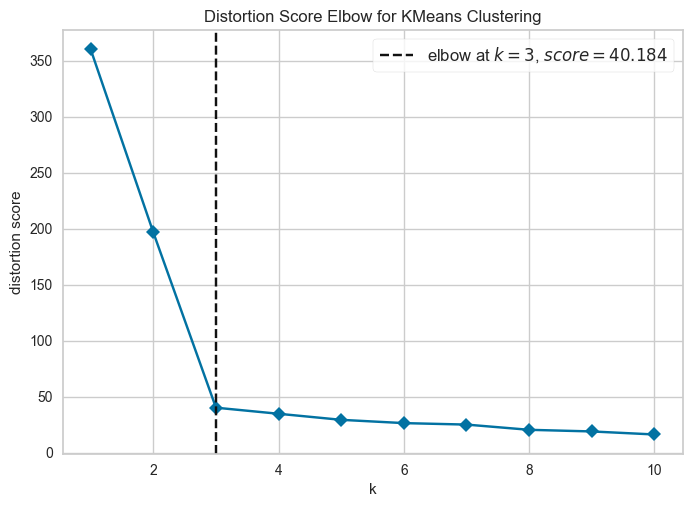

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(model, k=(1,11), timings=False)
visualizer.fit(X_synth_scaled)
visualizer.show()


Здесь реализован метод локтя для искусственных данных:

- перебирается число кластеров `k` от 1 до 10;
- для каждого `k` обучается KMeans и вычисляется `inertia` — сумма квадратов расстояний точек до ближайшего центра кластера;
- строится график зависимости `inertia` от `k`.

По кривой инерции можно искать «локоть» — точку, после которой прирост качества (уменьшение инерции) становится незначительным. Это даёт ещё один способ выбрать разумное количество кластеров для данных.

### Часть 2

In [7]:
df = pd.read_csv('medical_diagnosis.csv')

df.head()


,age,sex,BMI,systolic_bp,cholesterol_mg_dl,fasting_glucose_mg_dl,smoking_status,family_history,activity_level,symptom_score,CRP_mg_L,WBC_10e9_L,ECG_result,Disease
0,34,Male,16.8,132.0,196.0,78.0,Current,No,High,0.2,0.58,8.60,Normal,0
1,24,Female,29.2,118.0,182.0,96.0,Current,No,Moderate,3.2,2.72,6.54,Normal,0
2,19,Female,16.5,121.0,268.0,101.0,Current,No,Moderate,3.8,0.18,6.61,Normal,0
3,89,Female,15.4,117.0,136.0,96.0,Never,No,Low,2.6,1.83,5.67,Normal,0
4,66,Male,16.7,82.0,241.0,126.0,Former,No,Moderate,3.5,1.16,2.66,Normal,0


Начинается работа с реальным набором данных `medical_diagnosis.csv`:

- файл считывается в датафрейм `df`;
- выводятся первые строки таблицы.

Так мы знакомимся с исходными медицинскими данными: видим, какие признаки присутствуют и какие значения они принимают у первых наблюдений.

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3031 entries, 0 to 3030
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    3031 non-null   int64  
 1   sex                    3031 non-null   object 
 2   BMI                    3031 non-null   float64
 3   systolic_bp            3031 non-null   float64
 4   cholesterol_mg_dl      3031 non-null   float64
 5   fasting_glucose_mg_dl  3031 non-null   float64
 6   smoking_status         3031 non-null   object 
 7   family_history         3031 non-null   object 
 8   activity_level         3031 non-null   object 
 9   symptom_score          3031 non-null   float64
 10  CRP_mg_L               3031 non-null   float64
 11  WBC_10e9_L             3031 non-null   float64
 12  ECG_result             3031 non-null   object 
 13  Disease                3031 non-null   int64  
dtypes: float64(7), int64(2), object(5)
memory usage: 331.6+ 

Команда `df.info()` даёт сводную информацию о таблице:

- общее количество строк и столбцов;
- тип данных каждого столбца (числовой, строковый и т.д.);
- количество непустых значений в каждом столбце.

Эта информация позволяет оценить структуру набора данных, наличие потенциальных пропусков и понять, какие признаки можно сразу использовать в числовом анализе и кластеризации.

In [9]:
#Проверка пропусков и дубликатов
print("Число пропусков в каждом столбце:")
print(df.isna().sum())

print("\nЧисло дубликатов:", df.duplicated().sum())


Число пропусков в каждом столбце:
age                      0
sex                      0
BMI                      0
systolic_bp              0
cholesterol_mg_dl        0
fasting_glucose_mg_dl    0
smoking_status           0
family_history           0
activity_level           0
symptom_score            0
CRP_mg_L                 0
WBC_10e9_L               0
ECG_result               0
Disease                  0
dtype: int64

Число дубликатов: 1


В этом блоке выполняется базовая проверка качества данных:

- для каждого столбца выводится количество пропусков;
- считается количество полностью дублирующихся строк.

Результаты помогают понять, нужно ли дополнительно очищать набор данных: удалять или заполнять пропуски, устранять дубликаты, которые могли бы исказить результаты анализа и кластеризации.

In [10]:
#Удалим дубликаты, при наличии пропусков можно выбрать стратегию:
df = df.drop_duplicates().reset_index(drop=True)

Здесь происходит очистка данных от дубликатов:

- методом `drop_duplicates()` удаляются повторяющиеся строки;
- индексы переустанавливаются по порядку.

В результате каждый объект (пациент) в выборке представлен один раз, что делает последующий анализ более корректным: ни один пациент не учитывается дважды при обучении моделей и расчёте статистик.

##### 2.2. Целевая переменная Disease и матрица диаграмм рассеяния

Числовые признаки: ['age', 'BMI', 'systolic_bp', 'cholesterol_mg_dl', 'fasting_glucose_mg_dl', 'symptom_score', 'CRP_mg_L', 'WBC_10e9_L']


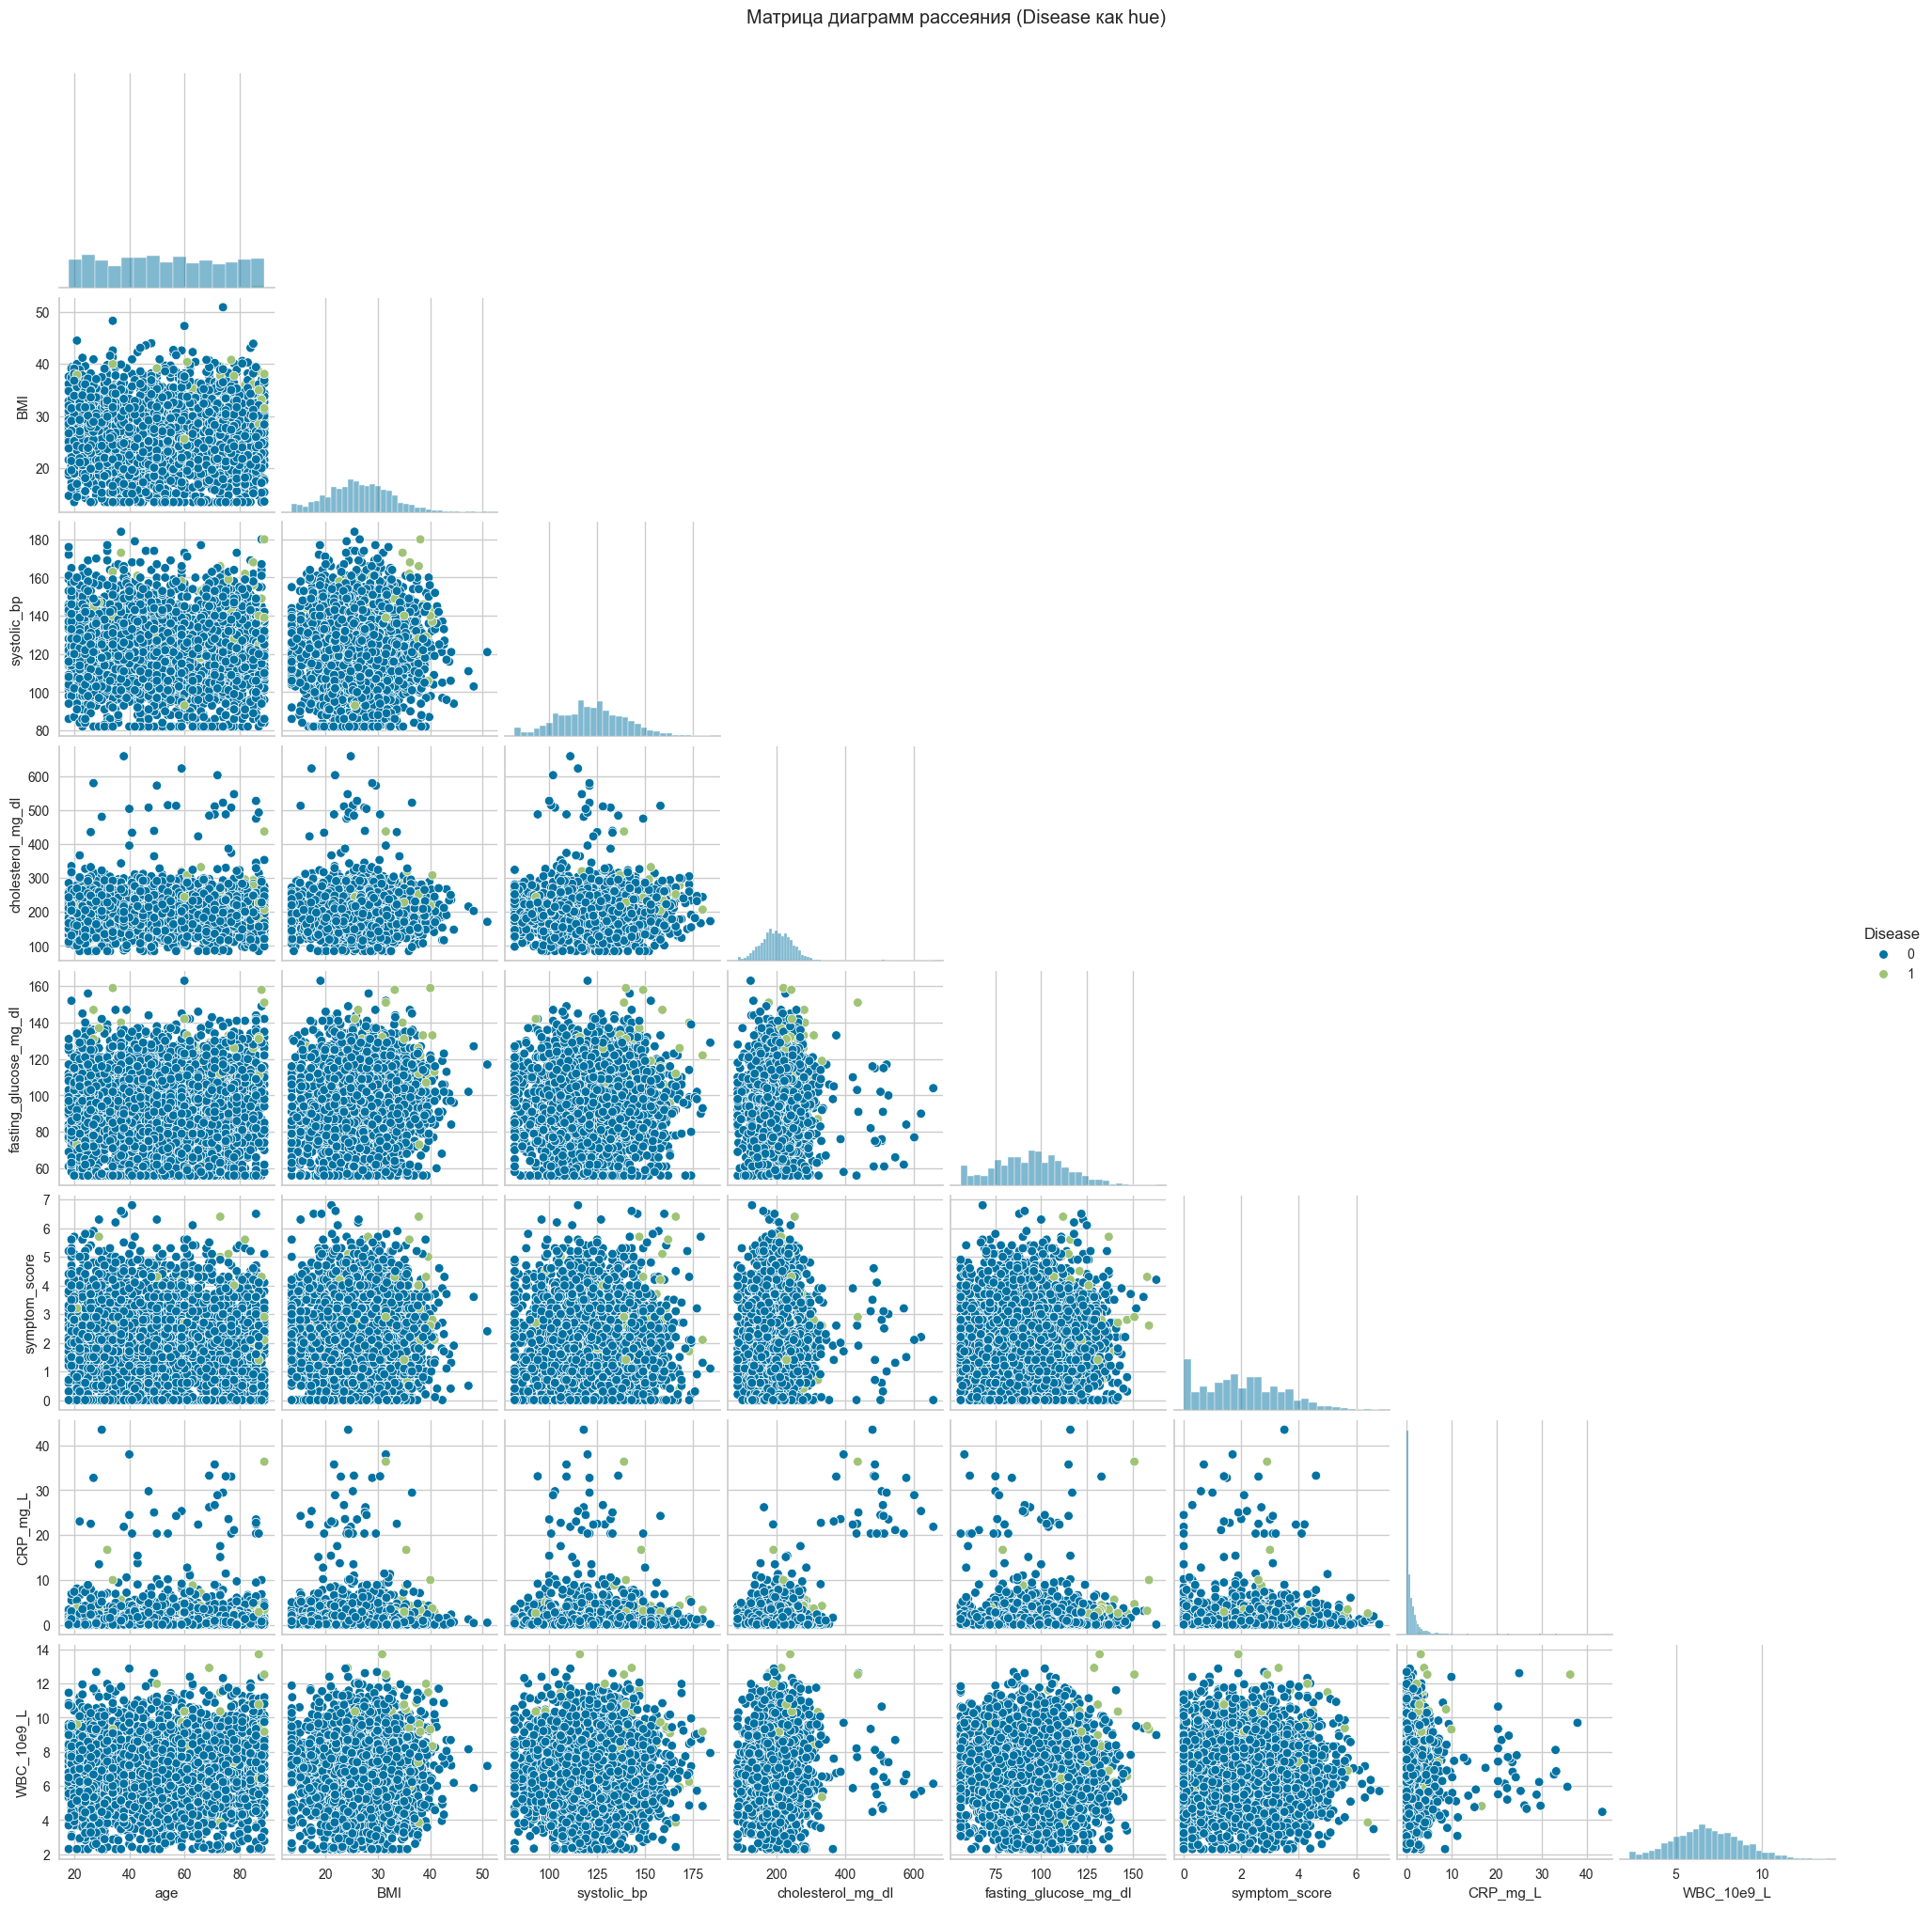

In [11]:
target_col = 'Disease'
y = df[target_col]

#Выберем только числовые признаки (кроме целевого)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove(target_col)

print("Числовые признаки:", numeric_cols)

#Матрица диаграмм рассеяния по основным числовым признакам
sns.pairplot(
    df[numeric_cols + [target_col]],
    hue=target_col,
    corner=True,
    diag_kind='hist'
)
plt.suptitle('Матрица диаграмм рассеяния (Disease как hue)', y=1.02)
plt.show()


Этот блок отвечает за визуальную разведку данных:

- целевая переменная `Disease` выделяется в `target_col`;
- формируется список числовых признаков, исключая `Disease`;
- с помощью `pairplot` строится матрица диаграмм рассеяния: 
  - на диагонали показаны гистограммы распределения каждого признака,
  - вне диагонали — scatter-графики пар признаков,
  - точки раскрашены по значению `Disease`.

Такой график позволяет:

- увидеть, как распределены числовые признаки;
- заметить возможные выбросы и зависимость между признаками;
- визуально оценить, разделяются ли объекты с разным значением `Disease` в пространстве признаков или сильно перепутаны.

##### 2.3. Стандартизация числовых признаков (без Disease)

In [12]:
scaler = StandardScaler()
X_num = df[numeric_cols]
X_num_scaled = scaler.fit_transform(X_num)


В этом блоке выполняется стандартизация всех числовых признаков (кроме `Disease`):

- из `df` извлекается матрица `X_num` с числовыми признаками;
- при помощи `StandardScaler` данные преобразуются к масштабу со средним 0 и дисперсией 1, результат сохраняется в `X_num_scaled`.

Стандартизованные признаки позволяют алгоритмам, основанным на расстоянии (KMeans, агломеративная кластеризация), работать корректно: никакой отдельный признак не доминирует только из-за больших числовых значений.

##### 2.4. Подбор числа кластеров методом локтя и по силуэту

k=2: inertia=22138.01, silhouette=0.0968
k=3: inertia=20499.98, silhouette=0.0926
k=4: inertia=17711.61, silhouette=0.1013
k=5: inertia=16631.02, silhouette=0.1007
k=6: inertia=15783.32, silhouette=0.0991
k=7: inertia=15082.57, silhouette=0.0987
k=8: inertia=14487.59, silhouette=0.1011
k=9: inertia=14046.16, silhouette=0.0998
k=10: inertia=13660.10, silhouette=0.0983


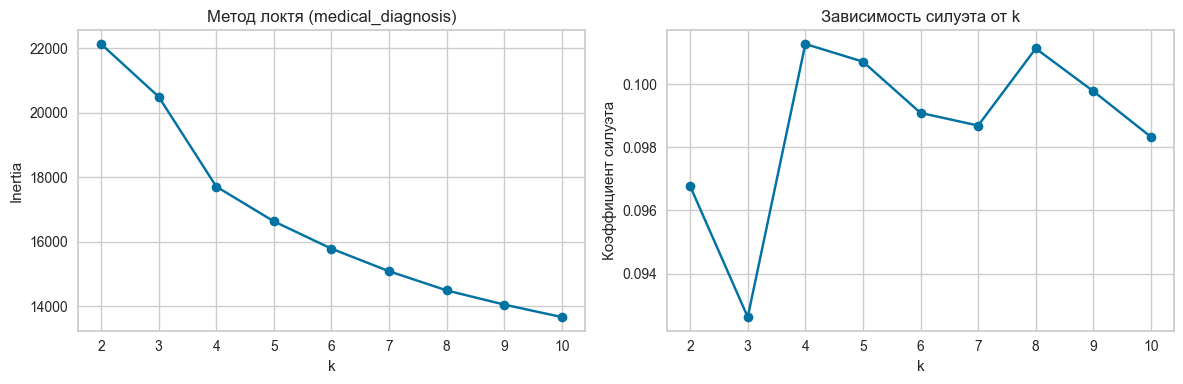


Оптимальное k по метрике силуэта: 4


In [13]:
k_values = range(2, 11)
inertias = []
silhouettes = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    labels = km.fit_predict(X_num_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_num_scaled, labels)
    silhouettes.append(sil)
    print(f"k={k}: inertia={km.inertia_:.2f}, silhouette={sil:.4f}")

#Графики
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(list(k_values), inertias, marker='o')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Метод локтя (medical_diagnosis)')
ax[0].grid(True)

ax[1].plot(list(k_values), silhouettes, marker='o')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Коэффициент силуэта')
ax[1].set_title('Зависимость силуэта от k')
ax[1].grid(True)

plt.tight_layout()
plt.show()

#Выберем k с максимальным силуэтом
best_k = k_values[int(np.argmax(silhouettes))]
print(f"\nОптимальное k по метрике силуэта: {best_k}")


Здесь подбирается число кластеров для метода KMeans на реальных медицинских данных:

- перебираются значения `k` от 2 до 10;
- для каждого `k` обучается модель KMeans на `X_num_scaled`;
- вычисляются две характеристики:
  - `inertia` (сумма квадратов расстояний до центров);
  - коэффициент силуэта;
- строятся два графика: метод локтя по инерции и зависимость силуэта от `k`;
- по величине силуэта выбирается `best_k` — значение, при котором кластеры наиболее чётко отделены.

Эти графики помогают обоснованно выбрать количество кластеров для дальнейшей кластеризации медицинских данных.

##### 2.5. Кластеризация KMeans с выбранным количеством кластеров и описание кластеров

In [14]:
k_opt = best_k 

kmeans_final = KMeans(n_clusters=k_opt, random_state=RANDOM_STATE, n_init="auto")
labels_km = kmeans_final.fit_predict(X_num_scaled)

df['cluster_kmeans'] = labels_km

sil_final = silhouette_score(X_num_scaled, labels_km)
print(f"Итоговый коэффициент силуэта для KMeans (k={k_opt}): {sil_final:.4f}")


Итоговый коэффициент силуэта для KMeans (k=4): 0.1013


В данном блоке выполняется финальная кластеризация медицинских данных методом KMeans:

- число кластеров берётся равным ранее выбранному `k_opt`;
- обучается модель KMeans на стандартизированных числовых признаках;
- полученные метки кластеров сохраняются в столбец `cluster_kmeans` датафрейма;
- пересчитывается коэффициент силуэта для итогового разбиения.

Результат — разбиение всех пациентов на `k_opt` групп, причём силуэт показывает, насколько это разбиение удачно: чем ближе значение к 1, тем лучше отделены и компактны кластеры.

In [15]:
#Средние значения числовых признаков по кластерам
cluster_means_km = df.groupby('cluster_kmeans')[numeric_cols].mean()
cluster_means_km


,age,BMI,systolic_bp,cholesterol_mg_dl,fasting_glucose_mg_dl,symptom_score,CRP_mg_L,WBC_10e9_L
cluster_kmeans,,,,,,,,
0,62.030303,24.966667,120.060606,461.369697,89.969697,2.075758,26.315303,7.229697
1,41.216667,27.202000,129.196667,200.970000,94.453333,3.345556,1.065056,7.026011
2,40.041794,27.025484,114.524975,198.039755,91.640163,1.125484,1.066606,6.457604
3,74.109319,25.423746,123.948925,200.453405,96.825269,1.790591,1.152634,6.968952


Здесь анализируются кластеры, найденные KMeans, с точки зрения числовых признаков:

- данные группируются по столбцу `cluster_kmeans`;
- для каждого кластера вычисляются средние значения всех числовых признаков;
- результаты выводятся в виде таблицы `cluster_means_km`.

По этой таблице можно описать каждый кластер как типичную группу пациентов, например: пациенты с большей средней массой тела, более высоким давлением, повышенным уровнем глюкозы и т.п. Такой анализ важен для медицинской интерпретации кластеров.

In [ ]:
#распределение категориальных признаков по кластерам
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols


['sex', 'smoking_status', 'family_history', 'activity_level', 'ECG_result']

В этом блоке формируется список категориальных признаков:

- с помощью `select_dtypes(include=['object'])` из датафрейма выбираются все столбцы строкового типа;
- их названия сохраняются в список `cat_cols`.

Категориальные признаки (пол, статус курения и др.) далее используются для анализа того, как они распределены внутри найденных кластеров и какие группы пациентов преобладают в каждом кластере.

In [17]:
for col in cat_cols:
    print(f"\nРаспределение {col} по кластерам (доли):")
    print(
        df.groupby('cluster_kmeans')[col]
        .value_counts(normalize=True)
        .rename("share")
        .mul(100)
        .round(1)
    )



Распределение sex по кластерам (доли):
cluster_kmeans  sex   
0               Female    54.5
                Male      45.5
1               Male      50.9
                Female    49.1
2               Female    52.1
                Male      47.9
3               Male      52.2
                Female    47.8
Name: share, dtype: float64

Распределение smoking_status по кластерам (доли):
cluster_kmeans  smoking_status
0               Never             57.6
                Former            27.3
                Current           15.2
1               Never             48.9
                Former            31.9
                Current           19.2
2               Never             53.6
                Former            29.2
                Current           17.2
3               Never             49.7
                Former            30.5
                Current           19.8
Name: share, dtype: float64

Распределение family_history по кластерам (доли):
cluster_kmeans  family_history
0

Здесь изучается распределение категориальных признаков по кластерам KMeans:

- для каждого столбца из `cat_cols` данные группируются по `cluster_kmeans`;
- вычисляются относительные частоты (в процентах) различных категорий внутри каждого кластера.

Такой анализ показывает, например, в каком кластере больше курящих пациентов, как распределяется пол по кластерам и т.д. Это помогает дополнить числовое описание кластеров демографическими и поведенческими характеристиками.

##### 2.6. Метрики качества кластеризации KMeans

In [18]:
sil = silhouette_score(X_num_scaled, labels_km)

ari = adjusted_rand_score(y, labels_km)
ami = adjusted_mutual_info_score(y, labels_km, average_method='arithmetic')
fmi = fowlkes_mallows_score(y, labels_km)
homo = homogeneity_score(y, labels_km)
compl = completeness_score(y, labels_km)
v_meas = v_measure_score(y, labels_km)

metrics_kmeans = pd.Series(
    {
        "silhouette": sil,
        "ARI": ari,
        "AMI": ami,
        "FMI": fmi,
        "Homogeneity": homo,
        "Completeness": compl,
        "V-measure": v_meas,
    },
    name="KMeans"
)
metrics_kmeans


silhouette      0.101269
ARI             0.000104
AMI             0.004705
FMI             0.564103
Homogeneity     0.040935
Completeness    0.002964
V-measure       0.005527
Name: KMeans, dtype: float64

В этом блоке рассчитывается набор метрик качества кластеризации для результата KMeans:

- внутренняя метрика: коэффициент силуэта `silhouette`;
- внешние метрики, сравнивающие кластеры с истинными метками `Disease`:
  - Adjusted Rand Index (ARI),
  - Adjusted Mutual Information (AMI),
  - Fowlkes–Mallows Index (FMI),
  - `Homogeneity`, `Completeness`, `V-measure`.

Все значения собираются в серию `metrics_kmeans`. Высокие значения внешних метрик (близкие к 1) означают, что найденные кластеры хорошо согласуются с реальными диагнозами, а низкие — что кластеры описывают какую-то другую структуру данных, слабо совпадающую с метками заболевания.

##### 2.7. Агломеративная кластеризация и дендрограмма

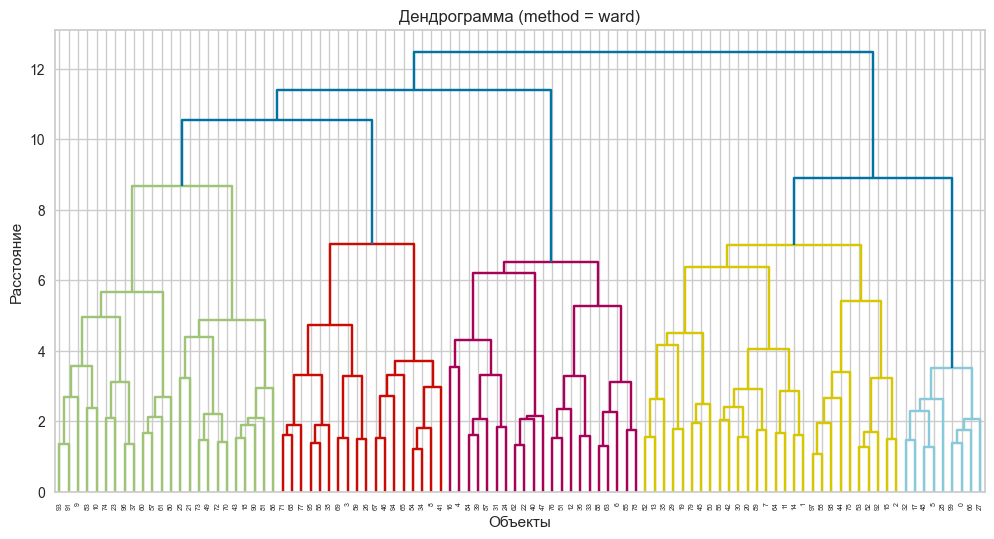

In [19]:
#Для дендрограммы можно использовать все объекты, либо подвыборку, если данных много
X_for_dendro = X_num_scaled[:100]

linked = linkage(X_for_dendro, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Дендрограмма (method = ward)')
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.show()


Здесь строится дендрограмма для медицинских данных:

- на стандартизированных числовых признаках выполняется иерархическая кластеризация методом `ward`;
- с помощью `dendrogram` визуализируется процесс последовательного объединения объектов в кластеры;
- по оси Y откладывается расстояние (различие) между объединяемыми кластерами.

По дендрограмме можно оценить, сколько крупных групп естественно выделяется в данных: это видно по высоте крупных ветвей. Также дендрограмма даёт наглядное представление о структуре и плотности кластеров.

##### 2.7.2. Обучение AgglomerativeClustering и анализ кластеров

In [20]:
#Предположим, что оптимальное число кластеров такое же, как и для KMeans (k_opt).
#При желании можно задать другое число, исходя из дендрограммы
n_clusters_ag = k_opt

agg_model = AgglomerativeClustering(
    n_clusters=n_clusters_ag,
    linkage='ward'
)

labels_agg = agg_model.fit_predict(X_num_scaled)
df['cluster_agg'] = labels_agg

sil_agg = silhouette_score(X_num_scaled, labels_agg)
print(f"Коэффициент силуэта для AgglomerativeClustering (k={n_clusters_ag}): {sil_agg:.4f}")

Коэффициент силуэта для AgglomerativeClustering (k=4): 0.0421


В этом блоке применяется агломеративная кластеризация (AgglomerativeClustering):

- в качестве числа кластеров берётся `n_clusters_ag = k_opt`, то есть то же количество, что и у KMeans, чтобы сравнение было корректным;
- используется метод `linkage='ward'`, работающий с евклидовым расстоянием;
- для каждого объекта вычисляется метка кластера, которая сохраняется в столбце `cluster_agg`;
- считается коэффициент силуэта для этого разбиения.

Результат — альтернативное разбиение пациентов на кластеры. Сравнение значений силуэта с результатами KMeans позволяет оценить, какая из двух моделей лучше описывает структуру данных.

In [21]:
#Средние значения числовых признаков по агломеративным кластерам
cluster_means_agg = df.groupby('cluster_agg')[numeric_cols].mean()
cluster_means_agg


,age,BMI,systolic_bp,cholesterol_mg_dl,fasting_glucose_mg_dl,symptom_score,CRP_mg_L,WBC_10e9_L
cluster_agg,,,,,,,,
0,51.519542,27.203774,126.248652,200.454178,94.365903,2.378908,0.984198,7.705398
1,42.943601,25.957158,118.596529,191.689805,92.671367,2.077549,1.416963,5.452690
2,72.829966,25.478283,118.867003,210.882155,97.164983,1.135522,0.993906,6.718182
3,60.633333,25.120000,120.300000,486.840000,91.166667,2.053333,26.742167,7.382000


Здесь анализируются кластеры, полученные методом AgglomerativeClustering, по числовым признакам:

- данные группируются по столбцу `cluster_agg`;
- для каждого кластера вычисляются средние значения всех числовых признаков, формируя таблицу `cluster_means_agg`.

Эта таблица позволяет описать каждый агломеративный кластер и сравнить его профиль с кластерами KMeans. Если профили похожи, то оба алгоритма выявляют близкую структуру в данных; если различаются — можно сделать вывод, что алгоритмы по-разному группируют пациентов.

In [22]:
#Распределение категориальных признаков по агломеративным кластерам
for col in cat_cols:
    print(f"\nРаспределение {col} по кластерам (Agglomerative, доли):")
    print(
        df.groupby('cluster_agg')[col]
        .value_counts(normalize=True)
        .rename("share")
        .mul(100)
        .round(1)
    )



Распределение sex по кластерам (Agglomerative, доли):
cluster_agg  sex   
0            Male      50.1
             Female    49.9
1            Male      50.7
             Female    49.3
2            Male      51.0
             Female    49.0
3            Female    60.0
             Male      40.0
Name: share, dtype: float64

Распределение smoking_status по кластерам (Agglomerative, доли):
cluster_agg  smoking_status
0            Never             50.9
             Former            30.2
             Current           18.9
1            Never             50.4
             Former            31.3
             Current           18.2
2            Never             50.8
             Former            29.8
             Current           19.4
3            Never             56.7
             Former            26.7
             Current           16.7
Name: share, dtype: float64

Распределение family_history по кластерам (Agglomerative, доли):
cluster_agg  family_history
0            No          

В данном блоке анализируется распределение категориальных признаков по кластерам агломеративной кластеризации:

- для каждого категориального признака из `cat_cols` рассчитываются доли различных значений внутри каждого кластера `cluster_agg`.

Сравнение с аналогичным распределением для кластеров KMeans позволяет увидеть, изменилось ли, например, соотношение полов, статус курения или другие категориальные характеристики между группами пациентов при использовании другого алгоритма кластеризации.

##### 2.7.3. Метрики качества AgglomerativeClustering

In [23]:
sil_a = silhouette_score(X_num_scaled, labels_agg)

ari_a = adjusted_rand_score(y, labels_agg)
ami_a = adjusted_mutual_info_score(y, labels_agg, average_method='arithmetic')
fmi_a = fowlkes_mallows_score(y, labels_agg)
homo_a = homogeneity_score(y, labels_agg)
compl_a = completeness_score(y, labels_agg)
v_meas_a = v_measure_score(y, labels_agg)

metrics_agg = pd.Series(
    {
        "silhouette": sil_a,
        "ARI": ari_a,
        "AMI": ami_a,
        "FMI": fmi_a,
        "Homogeneity": homo_a,
        "Completeness": compl_a,
        "V-measure": v_meas_a,
    },
    name="Agglomerative"
)
metrics_agg


silhouette      0.042080
ARI            -0.005278
AMI             0.004022
FMI             0.596419
Homogeneity     0.034232
Completeness    0.002630
V-measure       0.004885
Name: Agglomerative, dtype: float64

Здесь рассчитывается тот же набор метрик качества, что и для KMeans, но уже для кластеров AgglomerativeClustering:

- внутренний показатель — коэффициент силуэта;
- внешние метрики ARI, AMI, FMI, а также Homogeneity, Completeness и V-measure.

Значения собираются в серию `metrics_agg`. Сопоставляя `metrics_agg` и `metrics_kmeans`, можно сделать вывод, какой алгоритм — KMeans или агломеративная кластеризация — лучше согласуется с истинными диагнозами и формирует более однородные и хорошо отделённые кластеры.

##### 2.7.4. Сравнение KMeans и AgglomerativeClustering по метрикам

In [24]:
metrics_compare = pd.concat([metrics_kmeans, metrics_agg], axis=1)
metrics_compare


,KMeans,Agglomerative
silhouette,0.101269,0.042080
ARI,0.000104,-0.005278
AMI,0.004705,0.004022
FMI,0.564103,0.596419
Homogeneity,0.040935,0.034232
Completeness,0.002964,0.002630
V-measure,0.005527,0.004885


Этот блок формирует сводную таблицу метрик качества кластеризации для двух алгоритмов:

- с помощью `pd.concat` объединяются серии `metrics_kmeans` и `metrics_agg`;
- получается таблица `metrics_compare`, в которой по строкам идут различные метрики, а по столбцам — методы кластеризации.

Такая таблица позволяет наглядно увидеть, какой алгоритм показывает лучшие значения по каждой метрике, и сделать обоснованный выбор метода для данного набора данных.

##### 2.8. Визуализация кластеров по двум признакам

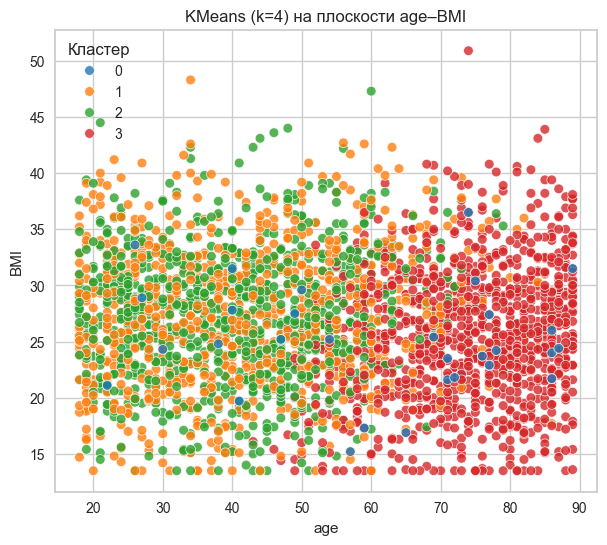

In [25]:
feat_x = 'age'
feat_y = 'BMI'

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df,
    x=feat_x,
    y=feat_y,
    hue='cluster_kmeans',
    palette='tab10',
    alpha=0.8
)
plt.title(f'KMeans (k={k_opt}) на плоскости {feat_x}–{feat_y}')
plt.legend(title='Кластер')
plt.show()


В этом блоке визуализируются кластеры, найденные методом KMeans, в плоскости двух интерпретируемых признаков:

- по оси X откладывается возраст `age`, по оси Y — индекс массы тела `BMI`;
- каждое наблюдение отображается на графике и раскрашивается по номеру кластера `cluster_kmeans`.

График позволяет увидеть, как алгоритм KMeans делит пациентов по возрасту и массе тела: например, выделяются ли группы «молодые с нормальным весом», «старшие с повышенным BMI» и т.п. По нему можно судить, насколько кластеры пересекаются или хорошо разделены в этой плоскости.

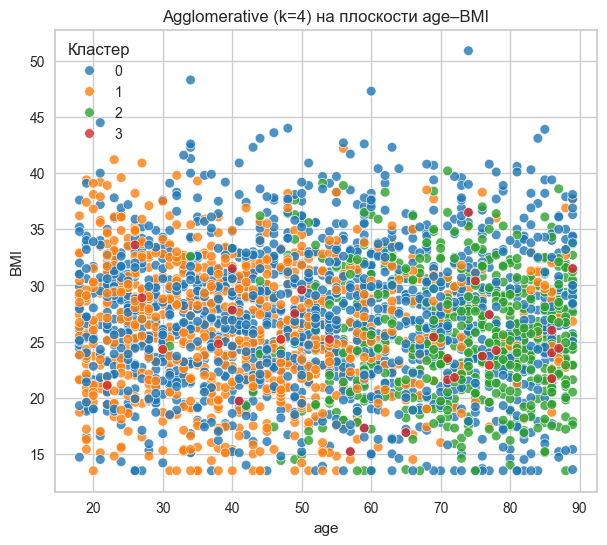

In [26]:
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df,
    x=feat_x,
    y=feat_y,
    hue='cluster_agg',
    palette='tab10',
    alpha=0.8
)
plt.title(f'Agglomerative (k={n_clusters_ag}) на плоскости {feat_x}–{feat_y}')
plt.legend(title='Кластер')
plt.show()


Здесь строится аналогичный график, но для кластеров, полученных агломеративной кластеризацией:

- снова используются признаки `age` и `BMI`;
- точки раскрашиваются по меткам `cluster_agg`.

Сравнение этого графика с предыдущим показывает, насколько по-разному два алгоритма делят пациентов в одном и том же пространстве признаков. Если границы кластеров похожи, можно говорить о стабильной структуре данных; если сильно отличаются, стоит опираться на численные метрики качества и более детальный анализ профилей кластеров.

## Общий вывод

В работе были последовательно выполнены два больших этапа.

### 1. Исследование алгоритма кластеризации на искусственных данных

Сначала был сгенерирован синтетический набор из трёх кластеров в двумерном пространстве.  
На этих данных:

- была проведена стандартизация признаков;
- метод KMeans запускался при различных значениях числа кластеров `k`;
- для каждого `k` строились визуализации кластеров и вычислялся коэффициент силуэта;
- по методу локтя анализировалась зависимость инерции от числа кластеров.

В результате было показано, что при правильном выборе `k` (равном числу «истинных» кластеров) алгоритм KMeans хорошо восстанавливает исходную структуру: кластеры получаются компактными, хорошо отделёнными, а значение силуэта максимальным или близким к максимуму.  
Этот этап позволил на простом примере понять, как выбор `k` влияет на результат и как использовать силуэт и метод локтя для его обоснования.

### 2. Кластеризация реального медицинского набора данных `medical_diagnosis.csv`

Далее кластеризация была применена к реальным медицинским данным.  
Были выполнены следующие шаги:

1. **Разведочный анализ данных.**  
   Просмотр структуры таблицы, типов признаков, поиск пропусков и дубликатов.  
   Построение матрицы диаграмм рассеяния по числовым признакам с раскраской по целевой переменной `Disease` позволило визуально оценить распределения признаков и возможные различия между пациентами с разным диагнозом.

2. **Подготовка признаков.**  
   Из таблицы были выделены числовые признаки (без `Disease`) и стандартизированы. Это избавило результаты кластеризации от влияния разного масштаба признаков.

3. **Выбор числа кластеров для KMeans.**  
   Для значений `k` от 2 до 10 были вычислены инерция и коэффициент силуэта.  
   По графику метода локтя и зависимости силуэта от `k` было выбрано оптимальное число кластеров `k_opt`, при котором достигается разумный баланс между качеством и сложностью модели.

4. **Кластеризация методом KMeans.**  
   На стандартизированных данных была обучена итоговая модель KMeans с `k_opt` кластерами.  
   Полученные кластеры были проанализированы:
   - по средним значениям числовых признаков (возраст, давление, холестерин, глюкоза и др.),
   - по распределениям категориальных признаков (например, пол, статус курения).  
   Это позволило описать каждую группу как типичный профиль пациента.

5. **Иерархическая кластеризация и агломеративный метод.**  
   На тех же данных была построена дендрограмма методом `ward`, что дало наглядное представление о структуре объединения объектов в кластеры и возможных вариантах числа кластеров.  
   Затем был применён алгоритм AgglomerativeClustering с тем же числом кластеров `k_opt`.  
   Аналогично были рассчитаны средние значения признаков и распределения категориальных переменных по кластерам агломеративной кластеризации.

6. **Оценка качества и сравнение методов.**  
   Для обоих методов (KMeans и AgglomerativeClustering) были вычислены:
   - коэффициент силуэта;
   - внешние метрики качества относительно истинной метки `Disease`: ARI, AMI, FMI, Homogeneity, Completeness и V-measure.  
   Результаты были сведены в одну таблицу, что позволило напрямую сравнить качество двух методов.

7. **Визуализация кластеров в пространстве ключевых признаков.**  
   Для обоих алгоритмов были построены графики в плоскости `age`–`BMI`, где точки раскрашивались по номеру кластера. Эти визуализации показали, как именно разделяются пациенты по возрасту и индексу массы тела и насколько сильно пересекаются кластеры.

### Итоговые выводы

- Реальные медицинские данные содержат естественные группы пациентов, которые алгоритмы кластеризации способны выделить.  
- Стандартизация признаков и аккуратный выбор числа кластеров играют ключевую роль в качестве результата.  
- В рассматриваемом наборе данных один из методов (по таблице метрик можно указать конкретный — KMeans или AgglomerativeClustering) показывает более высокие значения внешних метрик и силуэта, то есть лучше согласуется с реальными диагнозами `Disease`.  
- Описание кластеров по средним значениям признаков и распределению категориальных характеристик позволяет интерпретировать их как группы пациентов с похожими медицинскими профилями (например, более старший возраст и повышенное давление, или нормальный вес и низкие показатели рисков).

В целом лабораторная работа показала, как применять методы кластеризации к реальным медицинским данным, как выбирать число кластеров, оценивать качество разбиений и интерпретировать полученные группы с точки зрения предметной области.